In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from matplotlib.lines import Line2D
import numpy as np
import torchvision.utils as vutils
from functools import reduce, partial
import matplotlib.pyplot as plt

In [245]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def activity_square(vector):
    n = len(vector)
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)

def _plot_grad_flow(named_parameters):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                if p.grad is None:
                    print("%s missing grad" % n)
                else:
                    ave_grads.append(p.grad.abs().mean())
                    max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend([Line2D([0], [0], color="c", lw=4),
                    Line2D([0], [0], color="b", lw=4),
                    Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [450]:
import rsm_samplers
import rsm
import util
reload(rsm)
reload(rsm_samplers)
reload(util)

from torch.utils.data import DataLoader, BatchSampler

dataset = rsm_samplers.MNISTBufferedDataset("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

VISUAL = False
DEBUG = False

FLAT = True

predict_memory = None # 'column'

if VISUAL or DEBUG:
    MAX_BATCHES = 5
    EPOCHS = 5
    bs = 1
    plot_interval = 5
else:
    MAX_BATCHES = 30
    EPOCHS = 40
    bs=300
    plot_interval = 5

SEQ = [[2, 4, 0, 7, 8, 1, 6, 1, 8],[2, 7, 4, 9, 5, 9, 3, 1, 0],[5, 7, 3, 4, 1, 3, 1, 6, 4],[1, 3, 7, 5, 2, 5, 5, 3, 4],[2, 9, 1, 9, 2, 8, 3, 2, 7],[1, 2, 6, 4, 8, 3, 5, 0, 3],[3, 8, 0, 5, 6, 4, 1, 3, 9],[4, 7, 5, 3, 7, 6, 7, 2, 4]]
d_in = 28 ** 2
gamma = 0.0  # Inh decay
eps = 0.0  # Memory decay
d_out = tc if predict_memory else d_in
dropout_p = 0.0
pred_gain = 1.0
boost_strength = 0.4
BUFFER = False

if FLAT:
    m = 1000
    n = 1
    k = 275
    k_winner_cells = 1 
    do_inhibition=False
    mult_integration = True
else:
    m=200
    n=6
    k=50
    k_winner_cells=2
    do_inhibition=True
    mult_integration = False    
    
tc = m * n    

sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=bs,
                                            noise_buffer=BUFFER,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)
model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=m, n=n, k=k, eps=eps, gamma=gamma, 
                     k_winner_cells=k_winner_cells, bsz=bs,
                     boost_strat='col_boosting', # 'rsm_inhibition', 
                     pred_gain=pred_gain,
                     dropout_p=dropout_p,
                     x_b_norm=False,
                     mult_integration = mult_integration,
                     boost_strength=boost_strength,
                     mask_shifted_pi=False,
                     do_inhibition=do_inhibition,
                     debug_log_names=['x_a_batch'], #['pred_output', 'x_b', 'x_b_last'],
                     visual_debug=VISUAL, debug=DEBUG)

criterion = MSELoss()

LR = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
from util import plot_representation_similarity, plot_activity

x_b = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
phi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
psi = torch.zeros((bs, m*n), dtype=torch.float32, requires_grad=False)
hidden = (x_b, phi, psi)

# model._register_hooks()

for epoch in range(EPOCHS):
    total_loss = 0.0
    all_xb = []
    condtl_column_dists = {}
    last_out = None
    for i, (data, targets, pred_targets, input_labels) in enumerate(loader):

        hidden = _repackage_hidden(hidden)
        optimizer.zero_grad()
        
        out, hidden = model(data, hidden)
        x_b, phi, psi = hidden
        for _x_b, label, target in zip(x_b, input_labels, pred_targets):
            digit = label.item()
            next_digit = target.item()
            activity = _x_b.detach().view(m, -1)
            key = "%d-%d" % (digit, next_digit)
            if key not in condtl_column_dists:
                condtl_column_dists[key] = []
            condtl_column_dists[key].append(activity)
        
        all_xb.append(x_b)
        loss = None
        if predict_memory:
            # Loss computed between x^A generated at last time step and actual x^B
            if last_out is not None:
                loss = criterion(last_out.squeeze(), x_b.detach())
        else:
            loss = criterion(out, targets)
        
        if loss is not None:
            total_loss += loss.item()
            loss.backward()
        
#             _plot_grad_flow(model.named_parameters())
#             plt.show()
            optimizer.step()
        
        last_out = out
        
        if i >= MAX_BATCHES - 1:
            break
    
    if epoch % plot_interval == 0:
        x_b_mean = torch.cat(all_xb).mean().item()
        batches = MAX_BATCHES * (epoch+1)
        print('mb', batches, 'loss', total_loss / (i+1))
#         plot_representation_similarity(condtl_column_dists, n_labels=4, 
#                                        title=model.boost_strat,
#                                        fontsize=4)
        plt.show()
#         plot_activity(condtl_column_dists, n_labels=4, level='cell')
print('done')

mb 30 loss 0.8708412686983744
mb 180 loss 0.6981106042861939
mb 330 loss 0.6836544732252757
mb 480 loss 0.6769406080245972


In [ ]:
# Early train results on PAGI9

# Flat 1000 x 1, k100, boost 2, drop 0 - loss@1080 mb: .677-.680
# Flat 1000 x 1, k100, boost 2, drop 0.5 - loss@1080 mb: .685-.691
# Flat 1000 x 1, k100, boost 3, drop 0 - loss@1080 mb: .679-.680
# Flat 1000 x 1, k200, boost 2, drop 0 - loss@1080 mb: .676-.678
# Flat 1000 x 1, k250, boost 2, drop 0 - loss@1080 mb: .668-.674 
# Flat 1000 x 1, k300, boost 2, drop 0 - loss@1080 mb: .676-.678
# Flat 1000 x 1, k250, boost 1, drop 0 - loss@1080 mb: .671-.673
# Flat 1000 x 1, k250, boost 1.5, drop 0 - loss@1080 mb: .670-.674 
# Flat 1000 x 1, k250, boost 3, drop 0 - loss@1080 mb: .679-.680
# Flat 1000 x 1, k275, boost 2, drop 0 - loss@1080 mb: .675-.679
# Flat 1000 x 1, k275, boost 1, drop 0 - loss@1080 mb: .671-.671
# Flat 1000 x 1, k275, boost 1.25, drop 0 - loss@1080 mb: .669-.671
# Flat 1000 x 1, k275, boost 0.7, drop 0 - loss@1080 mb: .667-.668 <<<
# Flat 1000 x 1, k275, boost 0.5, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k300, boost 0.7, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k325, boost 0.7, drop 0 - loss@1080 mb: .675
# Flat 1000 x 1, k300, boost 0.5, drop 0 - loss@1080 mb: .674-.677
# Flat 1000 x 1, k250, boost 0.7, drop 0 - loss@1080 mb: .672
# Flat 1000 x 1, k275, boost 1.0, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k300, boost 1.0, drop 0 - loss@1080 mb: .671
# Flat 1000 x 1, k250, boost 2, drop 0, w/noise buffer - loss@1080 mb: 0.


[[2, 4, 0, 7, 8, 1, 6, 1, 8, -1], [2, 7, 4, 9, 5, 9, 3, 1, 0, -1], [5, 7, 3, 4, 1, 3, 1, 6, 4, -1], [1, 3, 7, 5, 2, 5, 5, 3, 4, -1], [2, 9, 1, 9, 2, 8, 3, 2, 7, -1], [1, 2, 6, 4, 8, 3, 5, 0, 3, -1], [3, 8, 0, 5, 6, 4, 1, 3, 9, -1], [4, 7, 5, 3, 7, 6, 7, 2, 4, -1]]
tensor([1])


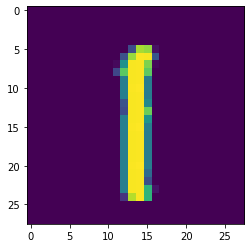

tensor([3])


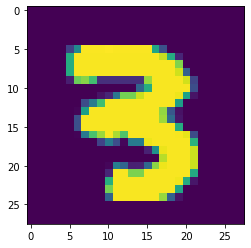

tensor([2])


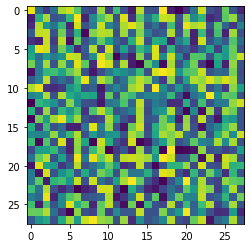

tensor([3])


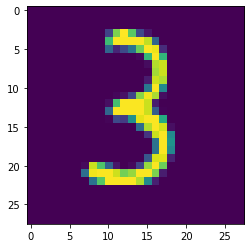

tensor([8])


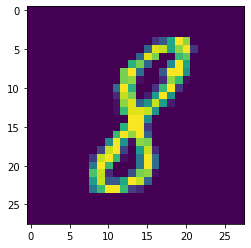

tensor([0])


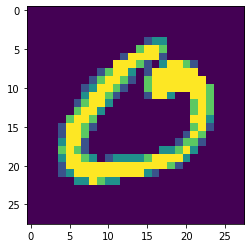

tensor([5])


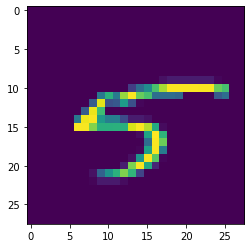

tensor([6])


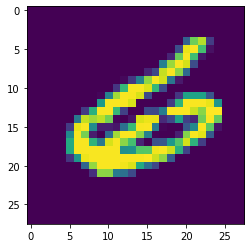

tensor([4])


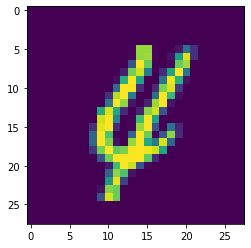

tensor([1])


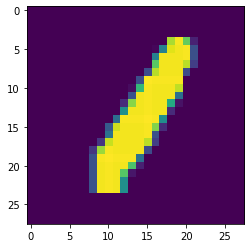

tensor([3])


KeyboardInterrupt: 

In [421]:
sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, 
                                            batch_size=1,
                                            noise_buffer=True,
                                            randomize_sequences=True, 
                                            random_mnist_images=True)

print(sampler.sequences)
loader = DataLoader(dataset,
             batch_sampler=sampler,
             collate_fn=rsm_samplers.pred_sequence_collate)


for i in range(11):
    inp_img, tgt_img, _, inp_label = next(iter(loader))
    print(inp_label)
    plt.imshow(inp_img.view(28, 28))
    plt.show()